In [52]:
from momentfm import MOMENTPipeline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch
from tqdm import tqdm

model = MOMENTPipeline.from_pretrained(
    "AutonLab/MOMENT-1-large", 
    model_kwargs={"task_name": "reconstruction"},
)
model.init()

from momentfm.utils.utils import control_randomness
control_randomness(seed=13) # Set random seeds for PyTorch, Numpy etc.

In [56]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [57]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

class SimpleTimeseriesDataset(Dataset):
    def __init__(self, file_path, target_cols=None, seq_len=512, stride=1, missing_ratio=0.01):
        self.seq_len = seq_len
        self.stride = stride
        
        # 1. 加载原始数据 (作为 Ground Truth)
        df = pd.read_csv(file_path)
        if target_cols:
            df = df[target_cols]
        else:
            df = df.select_dtypes(include=[np.number])
            
        # 保存原始真实数据
        self.raw_ground_truth = df.values.astype(float)
        
        # --- 创建带缺失值的版本 ---
        data_corrupted = self.raw_ground_truth.copy()
        if missing_ratio > 0:
            # 随机选择位置填入 NaN
            indices = np.random.choice(data_corrupted.size, replace=False, size=int(data_corrupted.size * missing_ratio))
            data_corrupted.flat[indices] = np.nan
        
        # 记录缺失位置 (1 表示缺失)
        self.real_mask = np.isnan(data_corrupted).astype(int)
        
        # 2. 标准化处理
        self.scaler = StandardScaler()
        # 基准标准化参数使用原始完整数据
        self.scaler.fit(self.raw_ground_truth)
        
        # 转换为 (C, L) 布局
        self.data_gt = self.scaler.transform(self.raw_ground_truth).T 
        # 损坏的数据集，缺失处补 0 输入模型
        self.data_corrupted = self.scaler.transform(np.nan_to_num(data_corrupted, nan=0.0)).T
        self.real_mask = self.real_mask.T
        
        self.n_channels, self.total_len = self.data_gt.shape

    def __len__(self):
        return (self.total_len - self.seq_len) // self.stride + 1

    def __getitem__(self, index):
        start = index * self.stride
        end = start + self.seq_len
        
        # 返回: 真实数据, 损坏数据, 缺失掩码
        return (torch.from_numpy(self.data_gt[:, start:end]).float(), 
                torch.from_numpy(self.data_corrupted[:, start:end]).float(),
                torch.from_numpy(self.real_mask[:, start:end]).long())

# --- 初始化 ---
my_dataset = SimpleTimeseriesDataset(
    file_path='../data/ETTh1.csv', 
    target_cols=['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL'],
    seq_len=512,
    stride=100,
    missing_ratio=0.01 
)

my_dataloader = DataLoader(my_dataset, batch_size=32, shuffle=False)

# 验证第一个 batch
batch_gt, batch_x, batch_m = next(iter(my_dataloader))
print(f"Dataset 修复：原始均值={batch_gt.mean():.4f}, 损坏版本均值={batch_x.mean():.4f}, 缺失点数={batch_m.sum()}")


Dataset 修复：原始均值=0.3355, 损坏版本均值=0.3200, 缺失点数=930


## 时间序列归补 (Imputation) 完整流程

下方的代码展示了如何使用 MOMENT 模型对整个测试集进行归补处理。主要步骤包括：
1. **维度转换**：将多变量数据 `[Batch, Channels, Length]` 展平为单变量格式 `[Batch * Channels, 1, Length]`，以符合 MOMENT 的单变量预训练逻辑。
2. **掩码生成**：模拟数据缺失或使用实际缺失掩码。
3. **模型推理**：使用 `reconstruction` 任务模式进行数据填充。
4. **结果还原**：将输出重塑回原始的多变量形状。


In [ ]:
from tqdm import tqdm
import numpy as np
import torch
from momentfm.utils.forecasting_metrics import mse, mae

# 1. 强制统一设备
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device).float()
model.eval()

trues, preds, masks = [], [], []

# 2. 推理循环
with torch.no_grad():
    for batch_gt, batch_x, batch_missing_mask in tqdm(my_dataloader, total=len(my_dataloader)):
        # 明确移动到设备
        batch_x = batch_x.to(device).float()
        batch_gt = batch_gt.to(device).float()
        batch_missing_mask = batch_missing_mask.to(device).long()
        
        B, C, L = batch_x.shape
        
        # --- 归一化处理 ---
        observed_mask = (batch_missing_mask == 0).float()
        obs_count = observed_mask.sum(dim=-1, keepdim=True) + 1e-5
        means = (batch_x * observed_mask).sum(dim=-1, keepdim=True) / obs_count
        stds = torch.sqrt(((batch_x - means)**2 * observed_mask).sum(dim=-1, keepdim=True) / obs_count) + 1e-5
        
        x_norm = (batch_x - means) / stds
        x_reshaped = x_norm.reshape((-1, 1, L)) 
        
        # 明确准备 Mask
        mask = batch_missing_mask.reshape((-1, L)) 
        input_mask = torch.ones_like(mask).to(device) # 再次确保在设备上

        # 3. 执行推理 (确保所有输入都在 device 上)
        output = model(x_enc=x_reshaped.to(device), 
                       input_mask=input_mask.to(device), 
                       mask=mask.to(device))
        
        # --- 反归一化还原预测值 ---
        reconstruction = output.reconstruction.reshape(B, C, L)
        reconstruction = reconstruction * stds + means
        
        # 4. 填充策略：仅在缺失点使用预测值，其它位置保留原始观测
        final_imputed = batch_x.clone()
        final_imputed[batch_missing_mask == 1] = reconstruction[batch_missing_mask == 1]
        
        preds.append(final_imputed.cpu().numpy())
        trues.append(batch_gt.cpu().numpy()) 
        masks.append(batch_missing_mask.cpu().numpy())

# 5. 合并结果
preds = np.concatenate(preds, axis=0)
trues = np.concatenate(trues, axis=0)
masks = np.concatenate(masks, axis=0)

print(f"\n设备: {device} | 修正统计量后的推理完成！")
masked_pts = (masks == 1)
if masked_pts.any():
    current_mse = mse(y=trues[masked_pts], y_hat=preds[masked_pts], reduction='mean')
    current_mae = mae(y=trues[masked_pts], y_hat=preds[masked_pts], reduction='mean')
    print(f"缺失点还原 MSE (相比原始真实值): {current_mse:.4f}")
    print(f"缺失点还原 MAE (相比原始真实值): {current_mae:.4f}")


100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


修正统计量后的推理完成！
缺失点还原 MSE (相比原始真实值): 2.7757


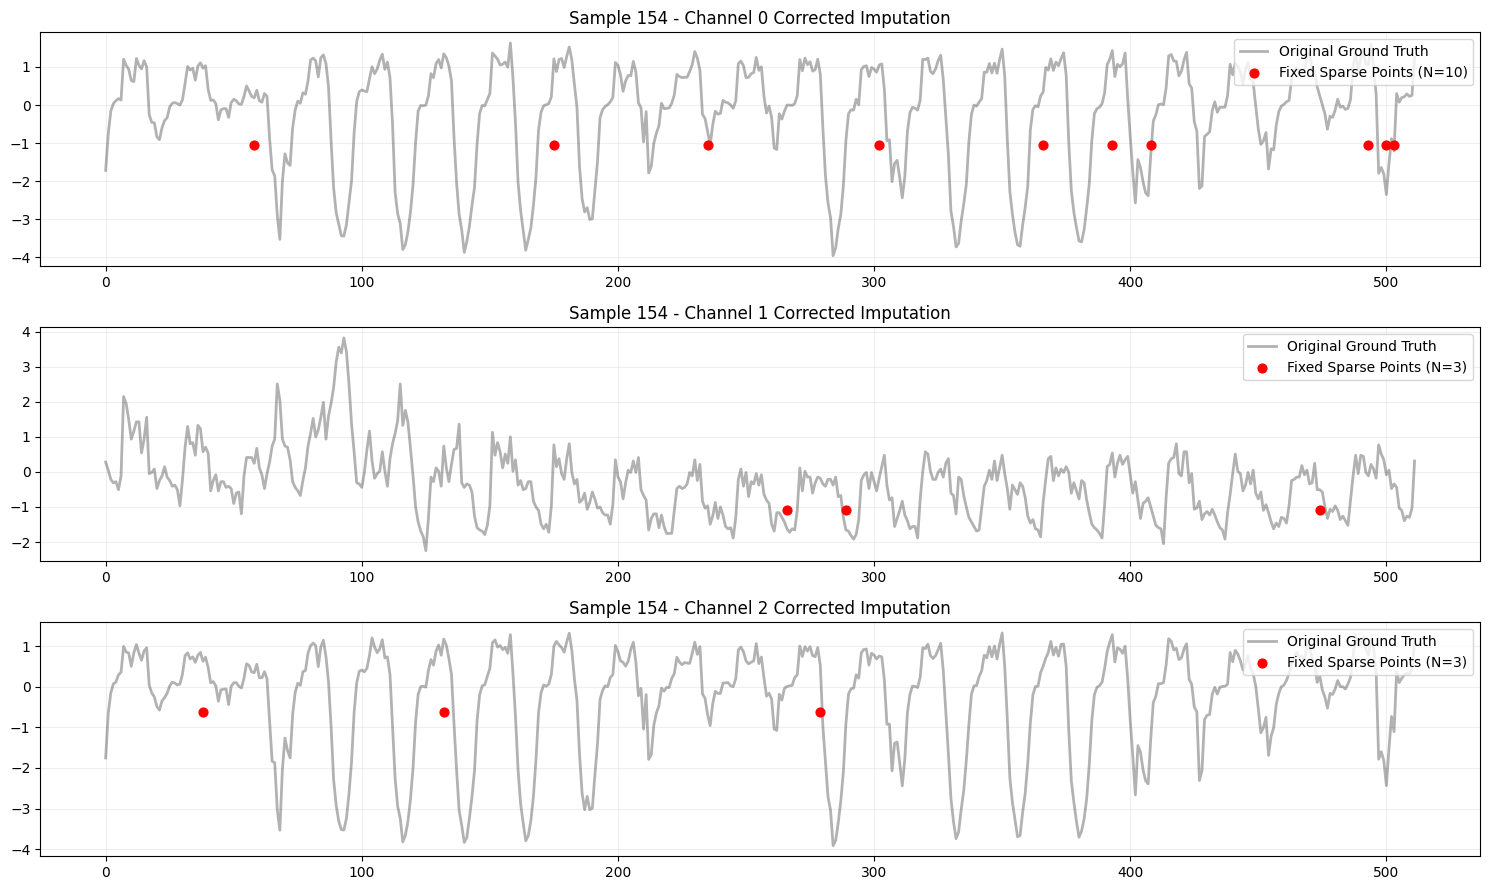

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- 修改：展示 3 个不同的随机样本 ---
n_samples_to_show = 3
selected_samples = np.random.choice(len(preds), n_samples_to_show, replace=False)
channels_to_plot = min(2, preds.shape[1]) # 每个样本展示前 2 个通道

fig, axs = plt.subplots(n_samples_to_show * channels_to_plot, 1, 
                        figsize=(15, 3 * n_samples_to_show * channels_to_plot))

for i, sample_idx in enumerate(selected_samples):
    for ch in range(channels_to_plot):
        ax_idx = i * channels_to_plot + ch
        ax = axs[ax_idx]
        
        gt = trues[sample_idx, ch, :]
        pd = preds[sample_idx, ch, :]
        mk = masks[sample_idx, ch, :]
        
        # 灰色背景：原始完整数据 (Ground Truth)
        ax.plot(gt, label='Original Ground Truth', color='black', alpha=0.2, linewidth=1.5)
        
        # 蓝色线：输入给模型的数据 (原本观测到的部分)
        observed_idx = np.where(mk == 0)[0]
        # 为了连线美观，我们直接画 pd (它在非缺失处等于 gt)
        ax.plot(pd, color='blue', alpha=0.4, label='Observed / Fixed' if ch==0 else "")
        
        # 红点：仅标出那 1% 的补全位置 (MOMENT 填充的点)
        imputed_idx = np.where(mk == 1)[0]
        if len(imputed_idx) > 0:
            ax.scatter(imputed_idx, pd[imputed_idx], color='red', s=30, 
                       label=f'Imputed Points (N={len(imputed_idx)})', zorder=5)
        
        ax.set_title(f"Sample {sample_idx} - Channel {ch}")
        if ch == 0: ax.legend(loc='upper right', fontsize=8)
        ax.grid(True, alpha=0.1)

plt.tight_layout()
plt.show()
